In [16]:
%cd algo_code

/home/themanuello/Documents/repo/FinancialPython/algo_code


/home/themanuello/.cache/pypoetry/virtualenvs/financialpython-cSpIym4p-py3.10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [18]:
import numpy as np
import polars as pl
import sys, os
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from pathlib import Path
from pybit.unified_trading import HTTP
import xgboost as xgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.api import VAR
from scipy.stats import norm

from algo_code import DATA_PATH
from algo_code.feature_engineering import split_target_features


In [45]:
p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    # 'lambda':5,
    #'gamma':2,
    'max_depth':5,
    # 'scale_pos_weight':2,
    'objective':'binary:logistic',
    'subsample': .8,
    # 'colsample_bytree': .9,
    'min_child_weight':1,
    'eta':0.02,
    'n_estimators':2000
}


def polars_time_series_cross_val(df: pl.DataFrame, features: list, target_var: str, n_splits: int = 5):
    n_symbols = df["symbol"].n_unique()
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=720*n_symbols)
    model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here

    # Cross-validation to find the best hyperparameters
    for train_index, test_index in tscv.split(df):
        train_data = df.slice(train_index[0], len(train_index))
        test_data = df.slice(test_index[0], len(test_index))
        print(f"Test Start: {train_data['date'].min()}")
        print(f"Test end: {train_data['date'].max()}")
        
        # Splitting features and labels
        train_features, train_labels = split_target_features(
            train_data.select(features + [target_var]),
            target_var=target_var
        )
        val_features, val_labels = split_target_features(
            test_data.select(features + [target_var]), 
            target_var=target_var
        )

        # Fit model (you can include hyperparameter tuning here)
        model.fit(
            train_features.to_pandas(),
            train_labels.to_pandas(), 
            eval_set=[
                (train_features.to_pandas(), train_labels.to_pandas()), 
                (val_features.to_pandas(), val_labels.to_pandas())
            ], 
            verbose=500
        )
    
    # This loop is only for cross-validation; the model will be re-trained below
    return model

# Final training using the entire dataset
def train_final_model(df: pl.DataFrame, target_var: str):
    model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here
    features, labels = split_target_features(df, target_var=target_var)
    # Train the final model on the entire dataset
    model.fit(features.to_pandas(), labels.to_pandas(), verbose=1)
    return model

In [38]:
df_train = pl.read_parquet("../data/train.parquet")
df_test = pl.read_parquet("../data/test.parquet")

In [44]:
df_train.head()

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,volume_pct_change,turnover_pct_change,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour,green_candle,red_candle,cons_green_candles,cons_red_candles,RSI_14,ema_short,ema_long,MACD,signal_line,macd_histogram,sma,std_dev,upper_band,lower_band,upper_band_pct_change,lower_band_pct_change,close_pct_change_lag_1,close_pct_change_lag_193,close_pct_change_lag_2,close_pct_change_lag_3,close_pct_change_lag_4,close_pct_change_lag_6,close_pct_change_lag_72,close_pct_change_lag_12,close_pct_change_lag_23,symbol_encoded,SP500_pct_change,NASDAQ_pct_change,VIX_pct_change,DXY_pct_change,US_FED_RATE,US_INFLATION,US_GDP,US_UNEMPLOYMENT
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64
1673942400000,1563.3,1569.21,1562.52,1568.98,1295.04546,2.0276e6,2023-01-17 08:00:00,"""ETH""",1,0,0.003633,0.299166,0.301393,-0.001069,1569.101538,0.000577,1555.79,0.001099,1524.0128,0.000986,1437.75195,2,1,8,0,1,0,1,54.09,1565.806034,1562.796544,3.00949,4.190794,-1.18,1565.5175,12.796795,1578.31,1552.72,0.000184,0.001735,0.002642,0.002323,-0.006721,0.001442,0.002443,0.004197,0.005618,-0.003073,0.004528,0,0.000643,0.001113,-0.002992,-0.001532,4.33,300.356,27164.359,3.4
1673942400000,0.3895,0.3909,0.388,0.3906,1.2801e6,498390.004613,2023-01-17 08:00:00,"""XRP""",0,0,0.002824,0.370688,0.374446,-0.00036,0.386177,0.000205,0.38756,0.000367,0.387644,0.000628,0.374022,2,1,8,0,1,0,1,56.72,0.386976,0.387266,-0.00029,-0.000831,0.0,0.38672,0.003039,0.39,0.38,0.0,0.0,0.007762,0.001148,-0.001808,0.006499,0.003652,0.003678,0.008663,-0.004331,0.00417,3,0.000643,0.001113,-0.002992,-0.001532,4.33,300.356,27164.359,3.4
1673942400000,0.0622,0.06244,0.0622,0.06243,580319.29,36162.282904,2023-01-17 08:00:00,"""TRX""",0,0,0.003698,-0.313457,-0.311505,-0.000313,0.062232,0.000093,0.062232,0.000841,0.061565,0.000716,0.058479,2,1,8,0,1,0,1,54.16,0.062208,0.062241,-0.000032,-0.000025,-0.0,0.062271,0.000328,0.06,0.06,0.0,0.0,0.00355,0.0,-0.000967,-0.000966,-0.000322,0.002906,0.004935,0.001914,0.000485,5,0.000643,0.001113,-0.002992,-0.001532,4.33,300.356,27164.359,3.4
1673942400000,21130.47,21205.47,21126.95,21201.43,193.277605,4.0924e6,2023-01-17 08:00:00,"""BTC""",0,0,0.003358,0.280996,0.285055,-0.000383,21143.136923,0.00047,20980.3002,0.001215,20586.5423,0.001072,19122.1706,2,1,8,0,1,0,1,57.84,21128.197766,21078.67658,49.521186,55.936693,-6.42,21111.4125,122.315903,21233.73,20989.1,0.000191,0.001763,0.003086,0.000639,-0.00393,-0.000251,0.001318,0.003015,0.005207,-0.001146,0.00383,1,0.000643,0.001113,-0.002992,-0.001532,4.33,300.356,27164.359,3.4
1673942400000,85.88,86.28,85.87,86.27,1795.88947,154459.434182,2023-01-17 08:00:00,"""LTC""",1,0,0.004541,0.845875,0.849575,-0.000754,85.918462,-0.000086,86.8914,0.000192,86.8595,0.000329,84.6848,2,1,8,0,1,0,1,49.79,85.976008,86.268083,-0.292074,-0.340271,0.05,86.149,0.516361,86.67,85.63,0.000115,0.000117,0.003505,0.000972,-0.005809,0.000814,0.008324,0.000117,0.007679,-0.00241,0.006202,7,0.000643,0.001113,-0.002992,-0.001532,4.33,300.356,27164.359,3.4


# TRAIN

In [40]:
FEATURES = [col for col in df_train.columns if "pct_change" in col] \
    + ["dow","hour", "cons_green_candles", "cons_red_candles", "RSI_14", "macd_histogram"] \
    + ["symbol_encoded", "US_FED_RATE","US_INFLATION","US_UNEMPLOYMENT"]
print(FEATURES)

['close_pct_change', 'volume_pct_change', 'turnover_pct_change', 'SMA_close_pct_change_13', 'SMA_close_pct_change_50', 'SMA_close_pct_change_100', 'SMA_close_pct_change_200', 'upper_band_pct_change', 'lower_band_pct_change', 'close_pct_change_lag_1', 'close_pct_change_lag_193', 'close_pct_change_lag_2', 'close_pct_change_lag_3', 'close_pct_change_lag_4', 'close_pct_change_lag_6', 'close_pct_change_lag_72', 'close_pct_change_lag_12', 'close_pct_change_lag_23', 'SP500_pct_change', 'NASDAQ_pct_change', 'VIX_pct_change', 'DXY_pct_change', 'dow', 'hour', 'cons_green_candles', 'cons_red_candles', 'RSI_14', 'macd_histogram', 'symbol_encoded', 'US_FED_RATE', 'US_INFLATION', 'US_UNEMPLOYMENT']


In [46]:
# Run cross-validation to tune hyperparameters
cv_model = polars_time_series_cross_val(df_train, features=FEATURES, target_var='long_signal', n_splits=5)

print("Final Train")
# Train the final model using the entire dataset
final_model = train_final_model(df_train.select(FEATURES + ["long_signal"]), target_var='long_signal')

Test Start: 2023-01-17 08:00:00
Test end: 2024-04-02 11:00:00
[0]	validation_0-auc:0.65386	validation_1-auc:0.58764
[500]	validation_0-auc:0.82840	validation_1-auc:0.62741
[1000]	validation_0-auc:0.87619	validation_1-auc:0.62327
[1500]	validation_0-auc:0.90446	validation_1-auc:0.62116
[1999]	validation_0-auc:0.92448	validation_1-auc:0.61913
Test Start: 2023-01-17 08:00:00
Test end: 2024-05-02 11:00:00
[0]	validation_0-auc:0.64999	validation_1-auc:0.61960
[500]	validation_0-auc:0.82589	validation_1-auc:0.73601
[1000]	validation_0-auc:0.87183	validation_1-auc:0.72734
[1500]	validation_0-auc:0.89941	validation_1-auc:0.71943
[1999]	validation_0-auc:0.91920	validation_1-auc:0.71262
Test Start: 2023-01-17 08:00:00
Test end: 2024-06-01 11:00:00
[0]	validation_0-auc:0.64916	validation_1-auc:0.58298
[500]	validation_0-auc:0.82435	validation_1-auc:0.68117
[1000]	validation_0-auc:0.87041	validation_1-auc:0.66462
[1500]	validation_0-auc:0.89742	validation_1-auc:0.65739
[1999]	validation_0-auc:0.91

In [50]:
model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here
train_features, train_labels = split_target_features(df_train.select(FEATURES + ["long_signal"]), target_var='long_signal')
# Train the final model on the entire dataset
model.fit(train_features.to_pandas(), train_labels.to_pandas(), verbose=True)
model.get_num_boosting_rounds()

2000

In [51]:
from sklearn.metrics import roc_auc_score
y_hat = model.predict_proba(train_features.to_pandas())[:,1]
print(f"AUC on Train {roc_auc_score(train_labels.to_pandas(),y_hat)}")
test_features, test_labels = split_target_features(df_test.select(FEATURES + ["long_signal"]), target_var='long_signal')
y_hat = model.predict_proba(test_features.to_pandas())[:,1]
print(f"AUC on Test {roc_auc_score(test_labels.to_pandas(),y_hat)}")

AUC on Train 0.9047066873937188
AUC on Test 0.6953777228976697


# PLOT PRECISION OVER THRESHOLD


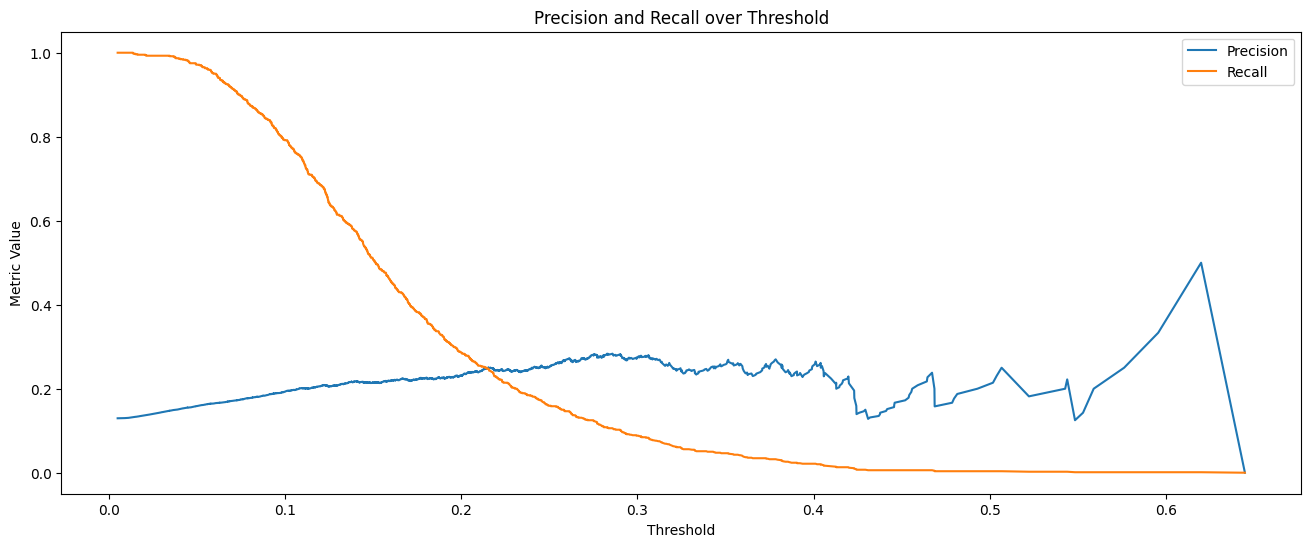

In [53]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(test_labels.to_pandas(), y_hat)
plt.figure(figsize=(16, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Precision and Recall over Threshold')
plt.legend() 

Optimal Threshold: 0.036705270409584045


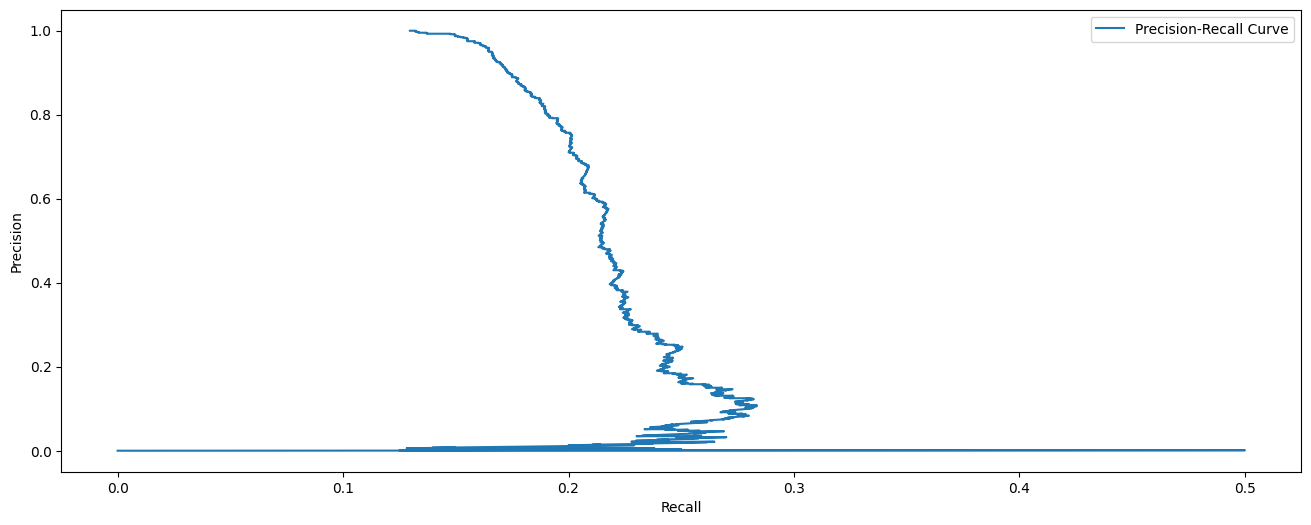

In [54]:
# get the threshold that maximizes the sum of precision and recall
optimal_threshold = thresholds[np.argmax(precision[:-1] + recall[:-1])]
print(f"Optimal Threshold: {optimal_threshold}")

# plot the precision and recall at the optimal threshold
plt.figure(figsize=(16, 6))
plt.plot(precision[:-1], recall[:-1], label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [55]:
from sklearn.metrics import confusion_matrix
print("TP: ",test_labels.sum())
confusion_matrix(test_labels.to_pandas(), np.where(y_hat > optimal_threshold, 1, 0))

TP:  shape: (1, 1)
┌─────────────┐
│ long_signal │
│ ---         │
│ i64         │
╞═════════════╡
│ 840         │
└─────────────┘


array([[ 898, 4742],
       [   8,  832]])

In [56]:
confusion_matrix(test_labels.to_pandas(), np.where(y_hat >= optimal_threshold, 1, 0), normalize='true')

array([[0.15921986, 0.84078014],
       [0.00833333, 0.99166667]])

# NEXT STEP:
# 1) split train validation test set
# 2) rafforzare la cross validation
# 3) backtestare strategia

In [58]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

def backtest_strategy(
    df: pl.DataFrame,
    # start_date: pl.Datetime,
    # end_date: pl.Datetime,
    signal_column: str = "long_signal",
    pred_column: str = "y_hat",
    investment_amount: int = 1000,
    rr_ratio: int = 2,
    optimal_threshold: float = 0.5
):

    # Filter the dataframe for the specified date range
    # df_backtest = df.filter((pl.col('timestamp') >= start_date) & (pl.col('timestamp') <= end_date))
    df_backtest = df
    # Initialize portfolio value and position
    initial_balance = investment_amount
    pct_profit = .01 * rr_ratio
    pct_loss = -pct_profit / rr_ratio
    
    # Calculate position changes
    # df_backtest = df_backtest.with_columns([
    #     pl.when((pl.col(signal_column) == 1) & (pl.col(pred_column) >= optimal_threshold))
    #     .then(investment_amount / pl.col('close'))
    #     .otherwise(0).alias('position_change'),
    #     
    #     pl.when((pl.col(signal_column) == -1) & (pl.col(pred_column) < optimal_threshold))
    #     .then(-1)
    #     .otherwise(0).alias('close_position')
    # ])

    position_return = initial_balance * pl.col("pct_return")
    compound_balance = initial_balance * (1 + pl.col("pct_return")).cum_prod()
    df_backtest = df_backtest.with_columns(
        pl.when((pl.col(pred_column) == 1) & (pl.col(signal_column) == 1))
        .then(pct_profit)
        .when((pl.col(pred_column) == 1) & (pl.col(signal_column) == 0))
        .then(pct_loss)
        .otherwise(0)
        .alias("pct_return"),
    ).with_columns(
        (position_return).alias("position_return"),
        (initial_balance + position_return.cum_sum()).alias("balance"),
        (pl.col("pct_return") * compound_balance.shift(1).fill_null(initial_balance)).alias("compound_position_return"),
        (compound_balance).alias("compound_balance")
    )

    # Calculate returns
    df_backtest = df_backtest.with_columns([
        pl.col('balance').pct_change().alias('return')
    ])

 
    # Extract results
    portfolio_values = df_backtest['balance'].to_list()
    returns = df_backtest['balance'].drop_nulls().to_list()
    
    # Calculate metrics
    total_return = (portfolio_values[-1] - initial_balance) / initial_balance
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(365)  # Assuming 365 trading days in a year

    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    return df_backtest
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Portfolio value over time
    ax1.plot(df_backtest['date'], portfolio_values)
    ax1.set_title('Portfolio Value Over Time')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Portfolio Value ($)')
    
    # Returns distribution
    ax2.hist(returns, bins=50)
    ax2.set_title('Distribution of Returns')
    ax2.set_xlabel('Return')
    ax2.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    
    return portfolio_values, returns

In [59]:
df_backtest = df_test.with_columns(
    y_hat = pl.lit(np.where(y_hat >= optimal_threshold, 1, 0))
).select(pl.col("date"), pl.col("symbol"), pl.col("long_signal"), pl.col("y_hat"))


tmp = backtest_strategy(df_backtest)
tmp.tail()

Total Return: -3076.00%
Sharpe Ratio: -30.96


date,symbol,long_signal,y_hat,pct_return,position_return,balance,compound_position_return,compound_balance,return
datetime[μs],str,i8,i64,f64,f64,f64,f64,f64,f64
2024-09-29 11:00:00,"""LTC""",0,1,-0.01,-10.0,-29720.0,-3.0751e-13,3.0444e-11,0.000337
2024-09-29 11:00:00,"""DOGE""",0,1,-0.01,-10.0,-29730.0,-3.0444e-13,3.0139e-11,0.000336
2024-09-29 11:00:00,"""ADA""",0,1,-0.01,-10.0,-29740.0,-3.0139e-13,2.9838e-11,0.000336
2024-09-29 11:00:00,"""ATOM""",0,1,-0.01,-10.0,-29750.0,-2.9838e-13,2.9539e-11,0.000336
2024-09-29 11:00:00,"""SOL""",0,1,-0.01,-10.0,-29760.0,-2.9539e-13,2.9244e-11,0.000336


La funzione di backtesting cosi come è non va bene perchè:
1) indipendentemente dal calcolo cumulato o no del balance, tengo sempre in considerazione l'1% di rischio
   es ho 1000 usd, investo su btc, il bilancio diventerebbe 0. Quindi non potrei fare altri trade nel frattempo
2) se avessi più trade in parallelo, dovrei gestire il rischio cumulato e soprattutto dovrei partire con un budget maggiore
3) il bilancio finale che vedo sopra, cumulato o no, soffre del punto sopra

Si potrebbe gestire il tutto con una coda pari al numero di trade massimi che posso fare e di conseguenza l'importo max per ciascun trade che deve essere proporzionale al bilancio. Occorre gestire il caso in cui due trade devono essere fatti in parallelo.




In [19]:
tmp.group_by("date").agg(
    pl.col("balance").last(),
    pl.col("pct_return").sum()
)

date,balance,pct_return
datetime[μs],f64,f64
2024-06-04 18:00:00,147340.0,0.0
2023-01-26 00:00:00,116390.0,0.0
2023-06-04 06:00:00,122340.0,0.0
2023-08-15 20:00:00,126070.0,0.0
2024-03-22 20:00:00,142460.0,-0.02
…,…,…
2023-03-12 20:00:00,118620.0,0.12
2024-04-12 16:00:00,143850.0,0.0
2023-01-25 19:00:00,116360.0,0.14


In [21]:
tmp.with_columns(pl.col("date").dt.date().alias("ymd")).group_by("ymd").agg(
    pl.col("balance").first(),
    pl.col("pct_return").mean()
)

ymd,balance,pct_return
date,f64,f64
2023-07-17,5430.0,0.000741
2023-04-01,3970.0,0.000278
2024-09-06,14120.0,0.001343
2023-11-01,6220.0,0.00338
2023-06-23,5160.0,0.002917
…,…,…
2024-02-01,7800.0,0.001065
2024-07-05,11510.0,0.007176
2024-02-25,8240.0,0.0
